In [11]:
### 2024 JUL 20 ###

In [12]:
#options(warn=-1)
#options(dplyr.summarise.inform = FALSE)
#
#packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr",
#              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel",
#              "rlang","tidyr","magrittr","viridis","ggmap","spatialEco","bit64",
#              "randomForest","modelr","geojsonio","rgeos") #"hrbrthemes","RItools","Hmisc",
#package.check <- lapply(packages, FUN = function(x) {
#    suppressPackageStartupMessages(library(x, character.only = TRUE))
#})


In [1]:
library("terra")
library("dplyr")
library("sf")
library("sp")

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE



In [2]:
#conda install -c conda-forge r-s3
install.packages("s3")
library("s3")
#library("aws.s3")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# args = commandArgs(trailingOnly=TRUE)
# if (length(args)==0) {
#   stop("At least one argument must be supplied (input file).n", call.=FALSE)
# } else if (length(args)>=1) {
#  
#   iso3 <- args[1]  #country to process
#   gediwk <- args[2]   #the # of weeks GEDI data to use
#   mproc <- as.integer(args[3])#the number of cores to use for macthing 
# }

In [3]:
#To test, we define the variables manually. For final version, run the commented out section below
gediwk <- 24
iso3 <-"BLZ"

In [4]:
cat("Step 0: Loading global variables for", iso3, "with wk", gediwk, "data \n")

Step 0: Loading global variables for BLZ with wk 24 data 


In [5]:
#f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

matching_tifs <- c("wwf_biomes","wwf_ecoreg","lc2000","d2roads", "dcities","dem",
                   "pop_cnt_2000","pop_den_2000","slope", "tt2cities_2000", "wc_prec_1990-1999",
                   "wc_tmax_1990-1999","wc_tavg_1990-1999","wc_tmin_1990-1999" )


In [6]:
ecoreg_key <- read.csv(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))
#unlink(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))

allPAs <- readRDS(s3_get(paste(f.path,"WDPA_shapefiles/WDPA_polygons/",iso3,"_PA_poly.rds",sep="")))

MCD12Q1 <- rast(s3_get(paste(f.path,"GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep="")))
#projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
crs(MCD12Q1)  <- "epsg:6933"

world_region <- rast(s3_get(paste(f.path,"GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep="")))
#projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
crs(world_region)  <- "epsg:6933"

adm <- st_read(s3_get(paste(f.path,"WDPA_countries/shp/",iso3,".shp",sep="")))
#adm <- vect(paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_countries/shp/",iso3,".shp",sep=""))
adm_prj <- project(vect(adm), "epsg:6933")

load(s3_get(paste(f.path,"rf_noclimate.RData",sep="")))
#source(s3_get(paste(f.path,"matching_func.R",sep="")))
#source(s3_get(paste(f.path,"matching_func_2024.R",sep="")))


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/BLZ_PA_poly.rds already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/BLZ_PA_poly.rds

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINE

Reading layer `BLZ' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/BLZ.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 94 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -89.23651 ymin: 15.87965 xmax: -87.78307 ymax: 18.49076
Geodetic CRS:  WGS 84


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData



In [17]:
# STEP1. Create 1km sampling grid with points only where GEDI data is available; first check if grid file exist to avoid reprocessing 
#if(!file.exists(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))){
  cat("Step 1: Creating 1km sampling grid filter GEDI data for", iso3,"\n")
  GRID.lats <- rast(s3_get(paste(f.path,"EASE2_M01km_lats.tif", sep="")))
  GRID.lons <- rast(s3_get(paste(f.path,"EASE2_M01km_lons.tif", sep="")))
  GRID.lats.adm   <- crop(GRID.lats, adm_prj)
  GRID.lats.adm.m <- mask(GRID.lats.adm, adm_prj)
  GRID.lons.adm   <- crop(GRID.lons, adm_prj)
  GRID.lons.adm.m <- mask(GRID.lons.adm, adm_prj)
  rm(GRID.lats, GRID.lons, GRID.lats.adm, GRID.lons.adm)
  
  #1.3) extract coordinates of raster cells with valid GEDI data in them
  #gedi_folder <- paste(f.path,"WDPA_gedi_l2a+l2b_clean2/",iso3,"/",sep="")
  gedi_folder <- paste(f.path,"WDPA_gedi_L4A_tiles/",sep="")
  #iso3_tiles <- paste("/projects/my-public-bucket/AOIs/vero_1deg_tiles_",iso3,"/",sep="")
  #tileindex_df <- read.csv(paste("/projects/my-public-bucket/AOIs/vero_1deg_tileindex/tileindex_",iso3,".csv", sep=""))
  tileindex_df <- read.csv(s3_get(paste(f.path,"vero_1deg_tileindex/tileindex_",iso3,".csv", sep="")))
  iso3_tiles <- tileindex_df$tileindexiso3_tiles <- tileindex_df$tileindex
    
  GRID.coords <- data.frame()
  #for(i in 1:length(dir(gedi_folder))){
  #for(i in 1:length(dir(iso3_tiles))){
  for(i in 1:length(iso3_tiles)){
    # print(list.files(gedi_folder)[i])
    
    iso3_tile_in <- paste("tile_num_",iso3_tiles[i],sep="")
    
    #if(!file.exists(paste(gedi_folder,iso3_tile_in,"_L4A.gpkg",sep=""))){
    #    print(paste(iso3_tile_in," does not exist",sep=""))
    #    } else {
    print(paste(iso3_tile_in," processing",sep=""))
    #gedi_data <- read.csv(list.files(gedi_folder,full.names=TRUE)[i]) %>%
    gedi_data <- read_sf(s3_get(paste(gedi_folder,iso3_tile_in,"_L4A.gpkg",sep="")), int64_as_string = TRUE) %>%
      dplyr::select(lon_lowestmode,lat_lowestmode)
    gedi_data <- gedi_data %>% st_drop_geometry()
#    gedi_pts  <- SpatialPoints(coords=gedi_data[,c("lon_lowestmode","lat_lowestmode")],
#                               proj4string=CRS("+init=epsg:4326"))
#    gedi_pts_prj <- spTransform(gedi_pts, "+init=epsg:6933")
    gedi_pts  <- vect(gedi_data, geom=c("lon_lowestmode","lat_lowestmode"), crs="epsg:4326", keepgeom=FALSE)        
    gedi_pts_prj <- project(gedi_pts, "epsg:6933")
        
    gcount_ras <- rasterize(geom(gedi_pts_prj)[,c("x","y")], GRID.lons.adm.m, fun="count", background=NA)
    names(gcount_ras) <- "gshot_counts"
    #pxid <- raster::extract(gcount_ras,  gedi_pts_prj)
    pxid <- extract(gcount_ras, gedi_pts_prj)
    #gedi_pts_prj_sp <- gedi_pts_prj %>% SpatialPointsDataFrame(., data=data.frame(pxid))
    gedi_pts_prj$pxid <- pxid[,"gshot_counts"]
    gedi_pts_prj_sp <- gedi_pts_prj    
    gedi_pts_prj_sp$pxid[is.na(gedi_pts_prj_sp$pxid)] <- 0
    gedi_pts_prj_filtered <- gedi_pts_prj_sp[gedi_pts_prj_sp$pxid >= 1,]  #change the numeric threshold to filter with a different min # of GEDI shots in each 1km cell
    
    GRID.lons.overlap <- GRID.lons.adm.m[gedi_pts_prj_filtered]
    GRID.lats.overlap <- GRID.lats.adm.m[gedi_pts_prj_filtered]
    
    x.overlap <- GRID.lons.overlap[!is.na(GRID.lons.overlap)]
    y.overlap <- GRID.lats.overlap[!is.na(GRID.lats.overlap)]
    
    xy.overlap <- cbind(x.overlap,y.overlap)
    xy.overlap.clean <- unique(xy.overlap)
    
    GRID.coords <- rbind(GRID.coords, xy.overlap.clean)
    #}
  }
  #GRID.for.matching <- SpatialPoints(coords = GRID.coords, proj4string=CRS("+init=epsg:4326"))
  GRID.for.matching <- vect(GRID.coords, geom=c("x.overlap","y.overlap"), crs = "epsg:4326")
  #saveRDS(GRID.for.matching, file = paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))
saveRDS(GRID.for.matching, file = paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))
#} else if (file.exists(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) {
#  cat(paste("STEP 1: Grid file exists, no need to process grids for ",iso3, "\n"))
#}


Step 1: Creating 1km sampling grid filter GEDI data for BLZ 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lats.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lats.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lons.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/EASE2_M01km_lons.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_BLZ.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_BLZ.csv



[1] "tile_num_16273 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16273_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16273_L4A.gpkg



[1] "tile_num_16274 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16274_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16274_L4A.gpkg



[1] "tile_num_16275 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16275_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16275_L4A.gpkg



[1] "tile_num_16452 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16452_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16452_L4A.gpkg



[1] "tile_num_16453 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16453_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16453_L4A.gpkg



[1] "tile_num_16454 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16454_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16454_L4A.gpkg



[1] "tile_num_16455 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16455_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16455_L4A.gpkg



[1] "tile_num_16632 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16632_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16632_L4A.gpkg



[1] "tile_num_16633 processing"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16633_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_16633_L4A.gpkg



In [18]:
# STEP2. Clip sampling grid to nonPA areas within country & sample raster layers on nonPA grid
cat("Step 2.0: Reading 1k GRID from RDS for " ,iso3, "\n")
#GRID.for.matching <- readRDS(s3_get(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) 
#GRID.for.matching <- vect(GRID.for.matching)
GRID.for.matching

Step 2.0: Reading 1k GRID from RDS for  BLZ 


 class       : SpatVector 
 geometry    : points 
 dimensions  : 23013, 0  (geometries, attributes)
 extent      : -89.22718, -87.78527, 15.88484, 18.48531  (xmin, xmax, ymin, ymax)
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 

In [19]:
#if(!file.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep=""))){
#  if(!dir.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",sep=""))){
#      dir.create(paste(f.path,"WDPA_matching_points/",iso3,"/",sep=""))}    
  cat("Step 2.1: Preparing control dataset for", iso3, "\n")
  #GRID.pts.nonPA <- GRID.for.matching %>% spTransform(., "+init=epsg:4326")
  GRID.pts.nonPA <- project(GRID.for.matching, "epsg:4326")
  for(i in 1:length(allPAs)){
    PA          <- vect(allPAs[i,])
    PA_prj      <- project(PA, "epsg:6933")
    #PA_prj_buff <- gBuffer(PA_prj, width = 10000) #10km buffer
    PA_prj_buff <- buffer(PA_prj, width = 10000)
    PA2         <- project(PA_prj_buff, "epsg:4326")
    overlap     <- GRID.pts.nonPA[PA2]
    if(length(overlap)>0){
      GRID.pts.nonPA0 <- st_difference(sf::st_as_sf(GRID.pts.nonPA), sf::st_as_sf(PA2)) ##remove pts inside poly
      #GRID.pts.nonPA <- as(GRID.pts.nonPA0$geometry,'Spatial') %>% spTransform(., "+init=epsg:4326")
      GRID.pts.nonPA <- vect(GRID.pts.nonPA0$geometry)
      GRID.pts.nonPA <- project(GRID.pts.nonPA, "epsg:4326")
    } 
    # print(length(GRID.pts.nonPA))
  }
  nonPA_xy  <- geom(GRID.pts.nonPA)[,c("x","y")]
  colnames(nonPA_xy)  <- c("x","y")
  #nonPA_spdf  <- tryCatch(SpatialPointsDataFrame(nonPA_xy, data=data.frame(nonPA_xy),proj4string=CRS("+init=epsg:4326")),
  nonPA_spdf  <- tryCatch(vect(nonPA_xy, crs="epsg:4326"),      
                          error=function(cond){
                            cat("Country too samll, after buffer no grid left, so quit processing country", iso3, dim(nonPA_xy),"\n")
                            #writeLines("Country too samll, after buffer no grid left", paste(f.path,"WDPA_log/",iso3,"_log_control.txt", sep=""))
                            return(quit(save="no"))})
    
    
  for (j in 1:length(matching_tifs)){
    #ras <- raster(paste(f.path, "WDPA_input_vars_iso3/",iso3,"/",matching_tifs[j],".tif", sep=""))
    ras <- rast(s3_get(paste(f.path, "WDPA_input_vars_GLOBAL/",matching_tifs[j],".tif", sep="")))
    print(matching_tifs[j])
    ras_ex <- extract(ras, nonPA_spdf, method="simple", factors=FALSE)
    nm <- names(ras)
    #nonPA_spdf <- cbind(nonPA_spdf, ras_ex[,matching_tifs[j]])
    #names(nonPA_spdf)[j+2] <- matching_tifs[j]
    nonPA_spdf$nm <- ras_ex[, matching_tifs[j]]
    names(nonPA_spdf)[j] <- matching_tifs[j]
  }
  nonPA_spdf$x <- geom(nonPA_spdf)[,"x"]
  nonPA_spdf$y <- geom(nonPA_spdf)[,"y"]
  
  d_control <- nonPA_spdf
  d_control$status <- as.logical("FALSE")
  names(d_control) <- make.names(names(d_control), allow_ = FALSE)
  d_control <- data.frame(d_control) %>%
    dplyr::rename(
      land_cover = lc2000,
      slope = slope,
      elevation = dem,
      popden = pop.den.2000,
      popcnt=pop.cnt.2000,
      min_temp=wc.tmin.1990.1999,
      max_temp=wc.tmax.1990.1999,
      mean_temp = wc.tavg.1990.1999,
      prec = wc.prec.1990.1999,
      tt2city= tt2cities.2000,
      wwfbiom = wwf.biomes,
      wwfecoreg = wwf.ecoreg,
      d2city = dcities,
      d2road = d2roads,
      lon = x,
      lat = y)
  d_control$land_cover <- factor(d_control$land_cover, levels=sequence(7),
                                 labels = c("l1_forest",
                                            "l2_grassland",
                                            "l3_agriculture",
                                            "l4_wetlands",
                                            "l5_artificial",
                                            "l6_other land/bare",
                                            "l7_water"))
  d_control$wwfbiom <- factor(d_control$wwfbiom,
                           levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                           labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
  d_control$wwfecoreg <- factor(d_control$wwfecoreg,
                             levels = as.vector(ecoreg_key[,"ECO_ID"]),
                             labels = as.vector(ecoreg_key[,"ECO_NAME"]))
  
  
  d_control$UID <-  seq.int(nrow(d_control))
  
  #saveRDS(d_control, file=paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep="")) 
  saveRDS(d_control, file=paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep="")) 
#  filename_out <- paste(iso3,"_prepped_control_wk",gediwk,".RDS", sep="")
#  saveRDS(d_control, file = filename_out)  
  
#} else if (file.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_prepped_control_wk",gediwk,".RDS",sep=""))){
#  cat("Step 2.1: preppred control dataset already exists for", iso3, "no need for reprocessing\n")
#}


Step 2.1: Preparing control dataset for BLZ 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant through

[1] "wwf_biomes"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif



[1] "wwf_ecoreg"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif



[1] "lc2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif



[1] "d2roads"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dcities.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dcities.tif



[1] "dcities"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dem.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/dem.tif



[1] "dem"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_cnt_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_cnt_2000.tif



[1] "pop_cnt_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_den_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/pop_den_2000.tif



[1] "pop_den_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/slope.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/slope.tif



[1] "slope"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/tt2cities_2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/tt2cities_2000.tif



[1] "tt2cities_2000"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_prec_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_prec_1990-1999.tif



[1] "wc_prec_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmax_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmax_1990-1999.tif



[1] "wc_tmax_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tavg_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tavg_1990-1999.tif



[1] "wc_tavg_1990-1999"


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmin_1990-1999.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wc_tmin_1990-1999.tif



[1] "wc_tmin_1990-1999"


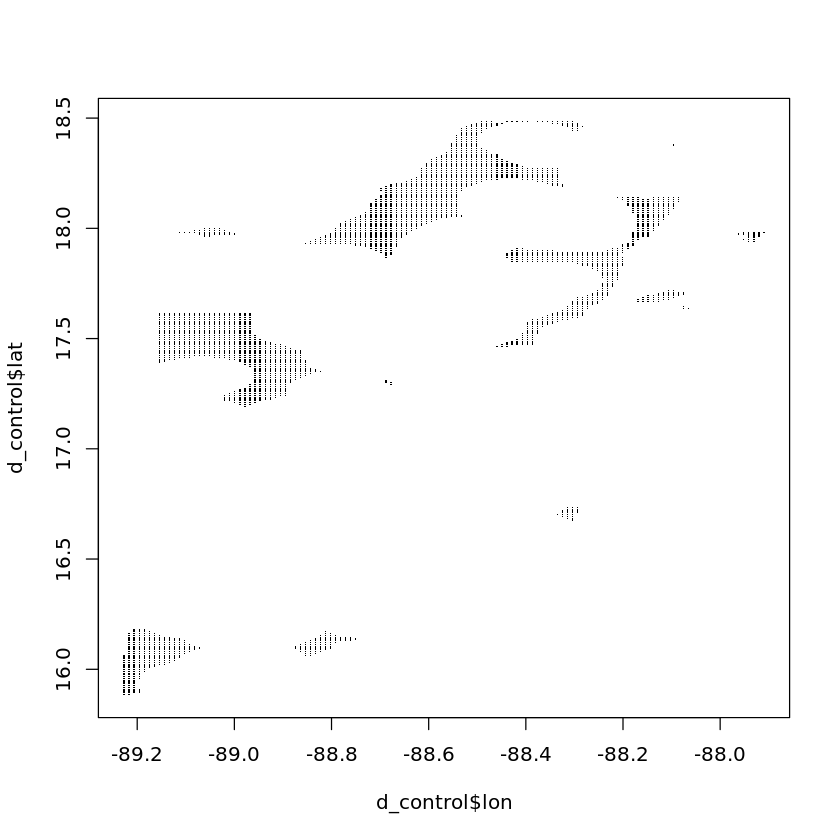

In [20]:
plot(d_control$lon, d_control$lat, pch=".")

In [21]:
#STEP3. Loop through all PAs in iso3 country:
# - clip sampling grid to each PA
# - sample raster layers on each PA grid
# - save each PA sample into prepped_pa_##.RDS file

cat("Step 3.0: Reading 1k GRID from RDS for " ,iso3, "\n")
#GRID.for.matching <- readRDS(s3_get(paste(f.path,"WDPA_grids/",iso3,"_grid_wk",gediwk,".RDS", sep=""))) 
#GRID.for.matching <- vect(GRID.for.matching)
GRID.for.matching

Step 3.0: Reading 1k GRID from RDS for  BLZ 


 class       : SpatVector 
 geometry    : points 
 dimensions  : 23013, 0  (geometries, attributes)
 extent      : -89.22718, -87.78527, 15.88484, 18.48531  (xmin, xmax, ymin, ymax)
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 

In [22]:
#if(length(dir(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""),pattern = paste(gediwk,".RDS",sep="")))==0){
#  if(!dir.exists(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""))){
#      dir.create(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""))}
  cat("Step 3.1: Processing prepped PA treatment dataset for ", iso3, "\n")
  for(i in 1:length(allPAs)){
    cat(iso3, i, "out of ", length(allPAs), "\n")
    testPA <- vect(allPAs[i,])
    testPA <- project(testPA, "epsg:4326")
    GRID.pts.testPA <- GRID.for.matching[testPA]
    
    #if(length(GRID.pts.testPA)>0){
    if(length(GRID.pts.testPA)>1){
      #testPA_xy <- coordinates(GRID.pts.testPA)
      testPA_xy <- geom(GRID.pts.testPA)[,c("x","y")]
      colnames(testPA_xy) <- c("x","y")
      #testPA_spdf <- SpatialPointsDataFrame(testPA_xy, data=data.frame(testPA_xy), proj4string=CRS("+init=epsg:4326"))
      testPA_spdf  <- vect(testPA_xy, crs="epsg:4326")
                              
        for (j in 1:length(matching_tifs)){
        #ras <- raster(paste(f.path, "WDPA_input_vars_iso3/",iso3,"/",matching_tifs[j],".tif", sep=""))
        ras <- rast(s3_get(paste(f.path, "WDPA_input_vars_GLOBAL/",matching_tifs[j],".tif", sep="")))
        ras <- crop(ras, testPA)
        ras_ex <- extract(ras, testPA_spdf, method="simple", factors=F)
        nm <- names(ras)
        #testPA_spdf <- cbind(testPA_spdf, ras_ex[,matching_tifs[j]])
        #names(testPA_spdf)[j+2] <- matching_tifs[j]
        testPA_spdf$nm <- ras_ex[, matching_tifs[j]]
        names(testPA_spdf)[j] <- matching_tifs[j]
  }
    testPA_spdf$x <- geom(testPA_spdf)[,"x"]
    testPA_spdf$y <- geom(testPA_spdf)[,"y"]
      
      d_pa <- testPA_spdf
      d_pa$status <- as.logical("TRUE")
      d_pa$DESIG_ENG <- testPA$DESIG_ENG
      d_pa$REP_AREA <- testPA$REP_AREA
      d_pa$PA_STATUS <- testPA$STATUS
      d_pa$PA_STATUSYR <- testPA$STATUS_YR
      d_pa$GOV_TYPE <- testPA$GOV_TYPE
      d_pa$OWN_TYPE <- testPA$OWN_TYPE
      d_pa$MANG_AUTH <- testPA$MANG_AUTH
      names(d_pa) <- make.names(names(d_pa), allow_ = FALSE)
      d_pa <- data.frame(d_pa) %>%
        dplyr::rename(
          land_cover = lc2000,
          slope = slope,
          elevation = dem,
          popden = pop.den.2000,
          popcnt=pop.cnt.2000,
          min_temp=wc.tmin.1990.1999,
          max_temp=wc.tmax.1990.1999,
          mean_temp = wc.tavg.1990.1999,
          prec = wc.prec.1990.1999,
          tt2city= tt2cities.2000,
          wwfbiom = wwf.biomes,
          wwfecoreg = wwf.ecoreg,
          d2city = dcities,
          d2road = d2roads,
          lon = x,
          lat = y)
      d_pa$land_cover <- factor(d_pa$land_cover, levels=sequence(7),
                                labels = c("l1_forest",
                                           "l2_grassland",
                                           "l3_agriculture",
                                           "l4_wetlands",
                                           "l5_artificial",
                                           "l6_other land/bare",
                                           "l7_water"))
      d_pa$wwfbiom <- factor(d_pa$wwfbiom,
                          levels = as.vector(unique(ecoreg_key[,"BIOME"])),
                          labels = as.vector(unique(ecoreg_key[,"BIOME_NAME"])))
      d_pa$wwfecoreg <- factor(d_pa$wwfecoreg,
                            levels = as.vector(ecoreg_key[,"ECO_ID"]),
                            labels = as.vector(ecoreg_key[,"ECO_NAME"]))
      
      d_pa$UID <- seq.int(nrow(d_pa))
      #saveRDS(d_pa, file = paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/","prepped_pa_",
      #                           testPA$WDPAID,"_wk",gediwk,".RDS", sep=""))
      saveRDS(d_pa, file = paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/","prepped_pa_",
                                 testPA$WDPAID,"_wk",gediwk,".RDS", sep=""))

    #filename_out <- paste("prepped_pa_",testPA$WDPAID,"_wk",gediwk,".RDS", sep="")
    #saveRDS(d_pa, file = filename_out)  

    }
  }
#} else if (length(dir(paste(f.path,"WDPA_matching_points/",iso3,"/",iso3,"_testPAs","/",sep=""),pattern = paste(gediwk,".RDS",sep="")))==length(allPAs)){
#  cat("Step 3.1: prepped PA treatment dataset already exists for ", iso3, "no need for reprocessing\n")
#}


Step 3.1: Processing prepped PA treatment dataset for  BLZ 
BLZ 1 out of  87 
BLZ 2 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 3 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 4 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 5 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 6 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 7 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 8 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 9 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 10 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 11 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 12 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 13 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 14 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 15 out of  87 
BLZ 16 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 17 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 18 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 19 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 20 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 21 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 22 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 23 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 24 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 25 out of  87 
BLZ 26 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 27 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 28 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 29 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 30 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 31 out of  87 
BLZ 32 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 33 out of  87 
BLZ 34 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 35 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 36 out of  87 
BLZ 37 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 38 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 39 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 40 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 41 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 42 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 43 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 44 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 45 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 46 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 47 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 48 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 49 out of  87 
BLZ 50 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 51 out of  87 
BLZ 52 out of  87 
BLZ 53 out of  87 
BLZ 54 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 55 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 56 out of  87 
BLZ 57 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 58 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 59 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 60 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 61 out of  87 
BLZ 62 out of  87 
BLZ 63 out of  87 
BLZ 64 out of  87 
BLZ 65 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 66 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 67 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 68 out of  87 
BLZ 69 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 70 out of  87 
BLZ 71 out of  87 
BLZ 72 out of  87 
BLZ 73 out of  87 
BLZ 74 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 75 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 76 out of  87 
BLZ 77 out of  87 
BLZ 78 out of  87 
BLZ 79 out of  87 
BLZ 80 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 81 out of  87 
BLZ 82 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 83 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 84 out of  87 
BLZ 85 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 86 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

BLZ 87 out of  87 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_biomes.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/wwf_ecoreg.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/lc2000.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input_vars_GLOBAL/d2roads.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_input

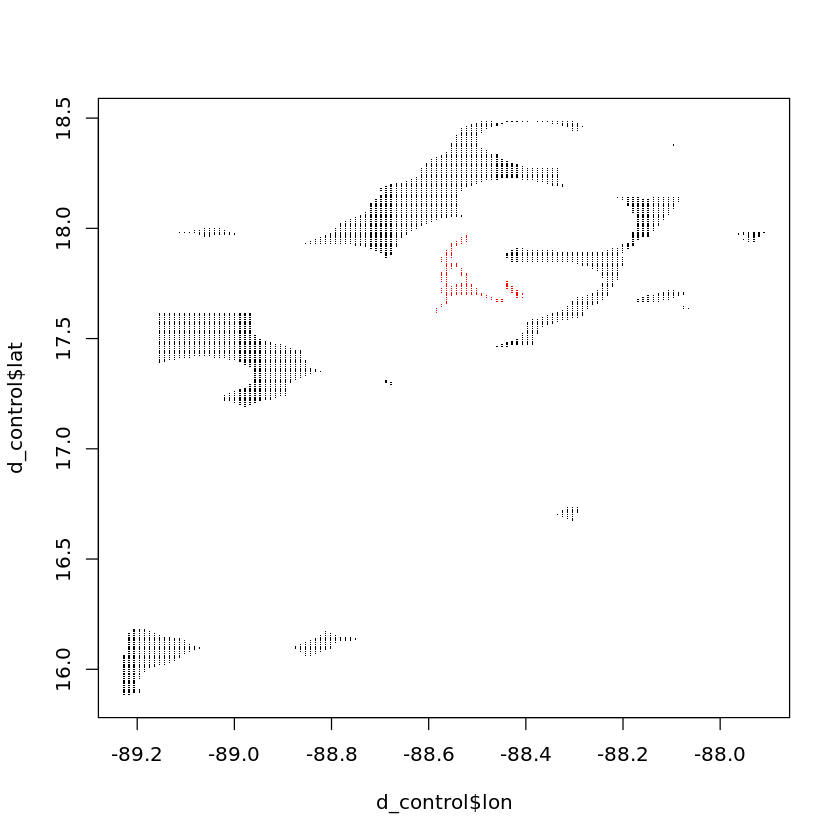

In [23]:
plot(d_control$lon, d_control$lat, pch=".")
points(d_pa$lon, d_pa$lat, pch=".", col="red")